In [114]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [115]:
np.random.seed(1)

In [116]:
carseats_df = pd.read_csv("Carseats.csv")

# Check for missing values
assert carseats_df.isnull().sum().sum() == 0

# Drop unused index
carseats_df = carseats_df.drop("Unnamed: 0", axis=1)

# Create binary variable High 1 if Sales > 8
carseats_df["High"] = (carseats_df["Sales"] > 8).astype(int)

carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0


We now use the respective function to fit a classification tree in order to predict High using all variables but Sales.
Please draw the tree and select the accuracy of the model for the training data.


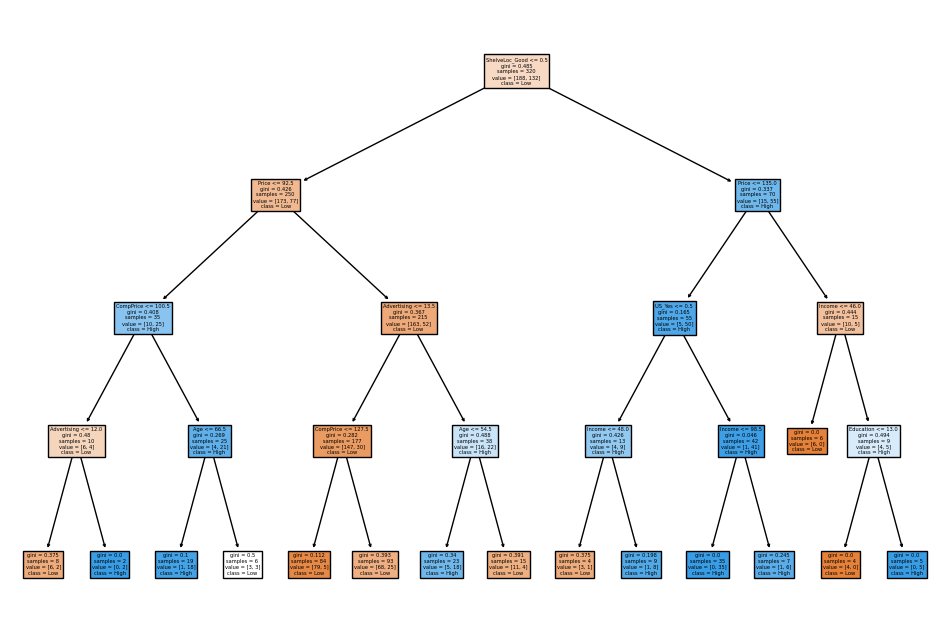

Accuracy on training data: 0.85


In [117]:
categorical_columns = ["ShelveLoc", "Urban", "US"]
one_hot_encoder = OneHotEncoder(drop="first", sparse_output=False)
X_categorical = one_hot_encoder.fit_transform(carseats_df[categorical_columns])

# Convert the one-hot encoded array into a DataFrame
X_categorical_df = pd.DataFrame(
    X_categorical, columns=one_hot_encoder.get_feature_names_out(categorical_columns)
)

# Drop the original categorical columns from the features
X = carseats_df.drop(["Sales", "High"] + categorical_columns, axis=1)
y = carseats_df["High"]

# Concatenate the one-hot encoded categorical columns with the remaining features
X = pd.concat([X, X_categorical_df], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the decision tree classifier
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=["Low", "High"], filled=True)
plt.show()

# Calculate accuracy on the training set
train_accuracy = clf.score(X_train, y_train)
print(
    f"Accuracy on training data: {train_accuracy}",
)

In [118]:
tn, fp, fn, tp = confusion_matrix(y, clf.predict(X)).ravel()

In [119]:
tn

223

In [120]:
# Get feature importances from the trained classifier
feature_importances = clf.feature_importances_

# Create a DataFrame to display feature importances along with their corresponding names
feature_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances}
)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# Display the top two important variables
top_two_variables = feature_importance_df.head(2)
print("Top two important variables:")
print(top_two_variables)

Top two important variables:
          Feature  Importance
7  ShelveLoc_Good    0.302345
4           Price    0.257395


In [121]:
# Fit Sklearn's tree classifier
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

# Get confusion matrix for test set
y_hat = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()

# Get proportion of correct classifications on test set
print("Test accuracy: {}".format(np.around(clf.score(X_test, y_test), 4)))

Test accuracy: 0.7625


In [122]:
tp

17

Text(0, 0.5, 'accuracy')

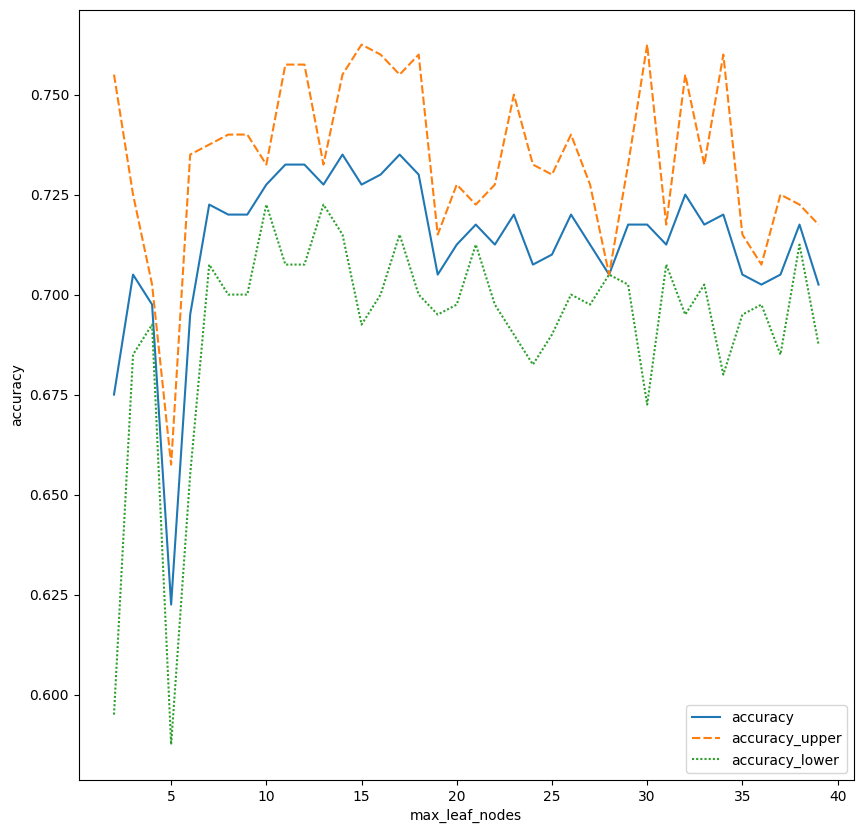

In [123]:
tuning_param = "max_leaf_nodes"
columns = [tuning_param, "accuracy", "accuracy_upper", "accuracy_lower"]

results = []
for m in np.arange(2, 40):
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=m)
    scores = cross_val_score(clf, X, y, cv=2)
    rmse = np.mean(scores)
    conf_int = np.std(scores) * 2
    results += [[m, rmse, rmse + conf_int, rmse - conf_int]]

# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10, 10))
sns.lineplot(data=plot_df)
plt.ylabel("accuracy")